In [26]:
import torch
import bcolz as bz
import pickle
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import time
import os 
import copy
import ast
from PIL import Image
from torchvision import datasets, models, transforms
from torch.autograd import Variable
# import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True






In [1074]:
# Hyperparameters
batch_size = 4
num_classes = 133
num_features = 2048
learning_rate = 1e-2
num_epochs = 500
step_size=7
gamma=0.1
weight_decay=1e-5

In [1075]:
#save paths
model_weights_path = '../models/checkpoint.pth.tar'
data_base_path = '../data/raw/dogImages'
class_to_idx_path = '../models/class_to_idx.pkl'

In [1128]:
#Data Transforms
preprocess = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 406], std=[0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 406], std=[0.229, 0.224, 0.225])
    ])
}


image_datasets = {x: datasets.ImageFolder(os.path.join(data_base_path, x), preprocess[x]) for x in ['train', 'valid']}
dataLoaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=1) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
class_to_idx = image_datasets['train'].class_to_idx
# print('class_names', class_names)
# print('class_to_idx', class_to_idx)
use_gpu = torch.cuda.is_available()

In [1129]:
pickle.dump((class_to_idx,), open(class_to_idx_path, 'wb'))

In [1130]:
class_to_index = pickle.load(open(class_to_idx_path, mode='rb'))
# print('class_to_index', class_to_index)

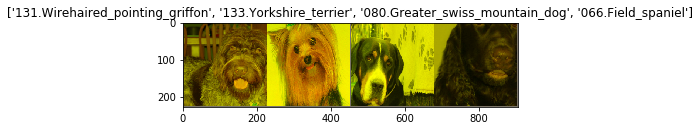

In [1131]:
# sample images
def imshow(inp, title=None):
    """imshow for tensor"""
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

# get a batch of training data
inputs, classes = next(iter(dataLoaders['train']))
#make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [1132]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    start = time.time()
    best_model_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs -1))
        print('-'*10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for data in dataLoaders[phase]:
                inputs, labels = data
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                optimizer.zero_grad()
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)
            epoch_loss = running_loss/dataset_sizes[phase]
            epoch_accuracy = running_corrects/dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_accuracy))
            
            if phase == 'valid' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_weights = copy.deepcopy(model.state_dict())
        print()
    
    run_time = time.time() - start
    print('Training completed in {:.0f}m and {:.0f}s'.format(run_time//60, run_time%60))
    print('Best Validation Accuracy: {:4f}'.format(best_accuracy))
    model.load_state_dict(best_model_weights)
    return model

In [1133]:
def visualize_model(model, num_images):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    for i, data in enumerate(dataLoaders['valid']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        outputs = models(inputs)
        _, preds = torch.max(outputs.data, 1)
        for k in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, image_so_far)
            ax.axis('off')
            ax.set_title('Predicted: {}'.format(class_names[preds[k]]))
            imshow(inputs.cpu().data[k])
            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

In [1134]:
pretrained_model = models.resnet152(pretrained=True)
# num_features = vgg19_bn.classifier.in_features
modules = list(pretrained_model.children())[:-1]
pretrained_model=nn.Sequential(*modules)
for param in pretrained_model.parameters():
    param.requires_grad = False
if use_gpu:
    pretrained_model = pretrained_model.cuda()

In [1135]:
def save_array(filename, arr):
    c=bz.carray(arr, rootdir=filename, mode='w')
    c.flush()

In [1136]:
def load_array(filename):
    return bz.open(filename)[:]

In [1137]:
#Reference: 
def extract_features(dataset):
    features = []
    labels_list = []
    for data in dataset:
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        x = pretrained_model(inputs)
        features.extend(x.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    features = np.concatenate([[feat] for feat in features])
    return (features, labels_list)

In [1138]:
%%time
conv_feat_train, labels_train = extract_features(dataLoaders['train'])

CPU times: user 1h 4min 38s, sys: 6min 29s, total: 1h 11min 8s
Wall time: 42min 50s


In [1139]:
save_array('../data/processed/conv_feat_train.bc', conv_feat_train)

In [1140]:
save_array('../data/processed/labels_train.bc', labels_train)

In [1141]:
%%time
conv_feat_val, labels_val = extract_features(dataLoaders['valid'])

CPU times: user 8min 5s, sys: 45.3 s, total: 8min 50s
Wall time: 5min 18s


In [1142]:
save_array('../data/processed/conv_feat_val.bc', conv_feat_val)

In [1143]:
save_array('../data/processed/labels_val.bc', labels_val)

In [1144]:
conv_feat_train = load_array('../data/processed/conv_feat_train.bc')
labels_train = load_array('../data/processed/labels_train.bc')
conv_feat_val = load_array('../data/processed/conv_feat_val.bc')
labels_val = load_array('../data/processed/labels_val.bc')

In [1145]:
conv_feat_train.shape

(6680, 2048, 1, 1)

In [1146]:
np.array(labels_train).shape

(6680,)

In [1147]:
np.array(conv_feat_val).shape

(835, 2048, 1, 1)

In [1148]:
# #### Model ####
# Feedforward Classifier
class Classifier(nn.Module):
    """Resnet50 -> AvgPool -> FC()[Softmax]
    """
    def __init__(self, num_features, num_classes):
        super(Classifier, self).__init__()
#         self.drop = nn.Dropout(p=0.75)
#         self.fc = nn.Linear(num_features, num_classes)
        self.classifier = nn.Sequential(
            nn.Linear(2048, num_classes),
#             nn.Dropout(p=0.5),
        )

    def forward(self, x):
#         print('x.size()', x.size())
        x = x.view(x.size(0), -1)
#         x = self.drop(x)
        x = self.classifier(x)
        return x

model = Classifier(num_features, num_classes)
print(model)

# If you are running a GPU instance, load the model on GPU
if use_gpu:
    model.cuda()

Classifier(
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=133)
  )
)


In [1149]:
weights, biases = [], []
for name, p in model.named_parameters():
   if 'bias' in name:
       biases += [p]
   else:
       weights += [p]


In [1150]:
criterion = nn.CrossEntropyLoss()
optimizer_conv_adam = optim.SGD([
  {'params': weights},
  {'params': biases, weight_decay:0}
], lr=1e-2, momentum=0.9, weight_decay=5e-5)

In [1151]:
def generator(features, labels, batch_size=32, shuffle=True):
    labels = np.array(labels)
    if shuffle:
        index = np.random.permutation(len(features))
        features = features[index]
        labels = labels[index]
    for i in range(0, len(features), batch_size):
        yield (features[i:i+batch_size], labels[i:i+batch_size])

In [1152]:
def train(model, dataset_sizes=None, train_features=None, train_labels=None, val_features=None, val_labels=None, criterion=None, optimizer=None, num_epochs=25, train=True, shuffle=None):
    start = time.time()
    best_model_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs -1))
        print('-'*10)
#         train_batches = generator(features=train_features, labels=train_labels, shuffle=shuffle, batch_size=batch_size)
#         val_batches = generator(features=val_features, labels=val_labels, shuffle=False, batch_size=batch_size)
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            running_loss = 0.0
            running_corrects = 0
            if phase == 'train':
                train_batches = generator(features=train_features, labels=train_labels, shuffle=shuffle, batch_size=batch_size)
                #scheduler.step()
                model.train()
                for data in train_batches:
                    inputs, labels = data
                    if use_gpu:
                        inputs, labels = Variable(torch.from_numpy(inputs).cuda()), Variable(torch.from_numpy(labels).cuda())
                    else:
                        inputs, labels = Variable(torch.from_numpy(inputs)), Variable(torch.from_numpy(labels))
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    optimizer = optimizer
                    optimizer.zero_grad()
                    _, preds = torch.max(outputs.data, 1)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.data[0] * inputs.size(0)
                    running_corrects += torch.sum(preds==labels.data)
            else:
                val_batches = generator(features=val_features, labels=val_labels, shuffle=False, batch_size=batch_size)
                model.eval()
                for data in val_batches:
                    inputs, labels = data
                    if use_gpu:
                        inputs, labels = Variable(torch.from_numpy(inputs).cuda()), Variable(torch.from_numpy(labels).cuda())
                    else:
                        inputs, labels = Variable(torch.from_numpy(inputs)), Variable(torch.from_numpy(labels))
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)
                    running_loss += loss.data[0] * inputs.size(0)
                    running_corrects += torch.sum(preds==labels.data)
            
            # Iterate over data
            epoch_loss = running_loss/dataset_sizes[phase]
            epoch_accuracy = running_corrects/dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_accuracy))
            
            if phase == 'valid' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_weights = copy.deepcopy(model.state_dict())
        print()
    
    run_time = time.time() - start
    print('Training completed in {:.0f}m and {:.0f}s'.format(run_time//60, run_time%60))
    print('Best Validation Accuracy: {:4f}'.format(best_accuracy))
    model.load_state_dict(best_model_weights)
    return model

In [1153]:
train(model,dataset_sizes=dataset_sizes, train_features=conv_feat_train, train_labels=labels_train, val_features=conv_feat_val, val_labels=labels_val, criterion=criterion, optimizer=optimizer_conv_adam, num_epochs=num_epochs, train=True, shuffle=True)

Epoch 0/499
----------
train Loss: 8.8465 Acc: 0.0341
valid Loss: 8.9849 Acc: 0.0754

Epoch 1/499
----------
train Loss: 7.9465 Acc: 0.0999
valid Loss: 9.0065 Acc: 0.1006

Epoch 2/499
----------
train Loss: 7.3615 Acc: 0.1347
valid Loss: 8.2118 Acc: 0.1090

Epoch 3/499
----------
train Loss: 6.9026 Acc: 0.1678
valid Loss: 8.1441 Acc: 0.1126

Epoch 4/499
----------
train Loss: 6.4998 Acc: 0.2054
valid Loss: 9.2000 Acc: 0.0838

Epoch 5/499
----------
train Loss: 6.1097 Acc: 0.2379
valid Loss: 8.7651 Acc: 0.1257

Epoch 6/499
----------
train Loss: 5.7683 Acc: 0.2588
valid Loss: 9.7110 Acc: 0.0946

Epoch 7/499
----------
train Loss: 5.3974 Acc: 0.2856
valid Loss: 9.2365 Acc: 0.1234

Epoch 8/499
----------
train Loss: 5.3296 Acc: 0.2969
valid Loss: 8.7539 Acc: 0.1401

Epoch 9/499
----------
train Loss: 4.8031 Acc: 0.3292
valid Loss: 10.0312 Acc: 0.0982

Epoch 10/499
----------
train Loss: 4.6052 Acc: 0.3436
valid Loss: 9.2591 Acc: 0.1186

Epoch 11/499
----------
train Loss: 4.2210 Acc: 0.38

train Loss: 0.8834 Acc: 0.7802
valid Loss: 8.1298 Acc: 0.1281

Epoch 95/499
----------
train Loss: 0.8258 Acc: 0.7943
valid Loss: 8.0503 Acc: 0.1377

Epoch 96/499
----------
train Loss: 0.6542 Acc: 0.8277
valid Loss: 7.8932 Acc: 0.1341

Epoch 97/499
----------
train Loss: 0.6342 Acc: 0.8347
valid Loss: 7.8689 Acc: 0.1377

Epoch 98/499
----------
train Loss: 0.5446 Acc: 0.8539
valid Loss: 7.8152 Acc: 0.1461

Epoch 99/499
----------
train Loss: 0.5461 Acc: 0.8572
valid Loss: 7.5958 Acc: 0.1413

Epoch 100/499
----------
train Loss: 0.3918 Acc: 0.9004
valid Loss: 7.7860 Acc: 0.1305

Epoch 101/499
----------
train Loss: 0.4210 Acc: 0.8901
valid Loss: 7.4243 Acc: 0.1485

Epoch 102/499
----------
train Loss: 0.2853 Acc: 0.9310
valid Loss: 7.1816 Acc: 0.1377

Epoch 103/499
----------
train Loss: 0.1294 Acc: 0.9747
valid Loss: 6.7441 Acc: 0.1497

Epoch 104/499
----------
train Loss: 0.0802 Acc: 0.9874
valid Loss: 6.6523 Acc: 0.1581

Epoch 105/499
----------
train Loss: 0.0409 Acc: 0.9978
valid 

train Loss: 1.4759 Acc: 0.6593
valid Loss: 7.7798 Acc: 0.1174

Epoch 189/499
----------
train Loss: 1.3429 Acc: 0.6801
valid Loss: 7.5285 Acc: 0.1317

Epoch 190/499
----------
train Loss: 1.4207 Acc: 0.6713
valid Loss: 7.4001 Acc: 0.1293

Epoch 191/499
----------
train Loss: 1.3896 Acc: 0.6641
valid Loss: 7.7833 Acc: 0.1305

Epoch 192/499
----------
train Loss: 1.2462 Acc: 0.7090
valid Loss: 7.7945 Acc: 0.1305

Epoch 193/499
----------
train Loss: 1.1752 Acc: 0.7180
valid Loss: 8.0570 Acc: 0.1377

Epoch 194/499
----------
train Loss: 1.0299 Acc: 0.7472
valid Loss: 7.5115 Acc: 0.1186

Epoch 195/499
----------
train Loss: 0.8709 Acc: 0.7804
valid Loss: 7.9474 Acc: 0.1174

Epoch 196/499
----------
train Loss: 0.8623 Acc: 0.7786
valid Loss: 7.9457 Acc: 0.1269

Epoch 197/499
----------
train Loss: 0.8345 Acc: 0.7856
valid Loss: 8.5758 Acc: 0.1150

Epoch 198/499
----------
train Loss: 0.6478 Acc: 0.8364
valid Loss: 7.8159 Acc: 0.1281

Epoch 199/499
----------
train Loss: 0.7408 Acc: 0.8148
v

train Loss: 0.0804 Acc: 0.9987
valid Loss: 5.6381 Acc: 0.1449

Epoch 283/499
----------
train Loss: 0.2489 Acc: 0.9557
valid Loss: 6.7691 Acc: 0.1186

Epoch 284/499
----------
train Loss: 1.0726 Acc: 0.7364
valid Loss: 8.0894 Acc: 0.1114

Epoch 285/499
----------
train Loss: 1.3652 Acc: 0.6787
valid Loss: 8.2950 Acc: 0.1234

Epoch 286/499
----------
train Loss: 1.5542 Acc: 0.6536
valid Loss: 7.8295 Acc: 0.1090

Epoch 287/499
----------
train Loss: 1.3232 Acc: 0.6801
valid Loss: 8.7606 Acc: 0.1042

Epoch 288/499
----------
train Loss: 1.3969 Acc: 0.6725
valid Loss: 7.7977 Acc: 0.1246

Epoch 289/499
----------
train Loss: 1.2992 Acc: 0.6849
valid Loss: 8.6060 Acc: 0.1222

Epoch 290/499
----------
train Loss: 1.1162 Acc: 0.7241
valid Loss: 8.0268 Acc: 0.1174

Epoch 291/499
----------
train Loss: 1.0056 Acc: 0.7551
valid Loss: 7.5527 Acc: 0.1246

Epoch 292/499
----------
train Loss: 0.9725 Acc: 0.7531
valid Loss: 7.8031 Acc: 0.1341

Epoch 293/499
----------
train Loss: 0.8567 Acc: 0.7805
v

train Loss: 0.0602 Acc: 0.9999
valid Loss: 5.4168 Acc: 0.1617

Epoch 377/499
----------
train Loss: 0.0630 Acc: 1.0000
valid Loss: 5.3972 Acc: 0.1533

Epoch 378/499
----------
train Loss: 0.0662 Acc: 1.0000
valid Loss: 5.3997 Acc: 0.1425

Epoch 379/499
----------
train Loss: 0.0717 Acc: 0.9999
valid Loss: 5.4215 Acc: 0.1569

Epoch 380/499
----------
train Loss: 0.1149 Acc: 0.9912
valid Loss: 5.8595 Acc: 0.1341

Epoch 381/499
----------
train Loss: 0.4820 Acc: 0.8955
valid Loss: 7.3433 Acc: 0.1126

Epoch 382/499
----------
train Loss: 1.4068 Acc: 0.6792
valid Loss: 8.3913 Acc: 0.1054

Epoch 383/499
----------
train Loss: 1.5547 Acc: 0.6446
valid Loss: 7.8156 Acc: 0.1234

Epoch 384/499
----------
train Loss: 1.3835 Acc: 0.6723
valid Loss: 7.5247 Acc: 0.1305

Epoch 385/499
----------
train Loss: 1.1849 Acc: 0.7141
valid Loss: 7.6799 Acc: 0.1365

Epoch 386/499
----------
train Loss: 1.1937 Acc: 0.7093
valid Loss: 7.5650 Acc: 0.1353

Epoch 387/499
----------
train Loss: 1.1264 Acc: 0.7254
v

train Loss: 0.0527 Acc: 0.9999
valid Loss: 5.4651 Acc: 0.1533

Epoch 471/499
----------
train Loss: 0.0561 Acc: 1.0000
valid Loss: 5.3869 Acc: 0.1617

Epoch 472/499
----------
train Loss: 0.0576 Acc: 1.0000
valid Loss: 5.4070 Acc: 0.1581

Epoch 473/499
----------
train Loss: 0.0604 Acc: 1.0000
valid Loss: 5.4685 Acc: 0.1593

Epoch 474/499
----------
train Loss: 0.0614 Acc: 1.0000
valid Loss: 5.3729 Acc: 0.1701

Epoch 475/499
----------
train Loss: 0.0657 Acc: 1.0000
valid Loss: 5.3852 Acc: 0.1521

Epoch 476/499
----------
train Loss: 0.0952 Acc: 0.9951
valid Loss: 5.4907 Acc: 0.1509

Epoch 477/499
----------
train Loss: 0.0866 Acc: 0.9990
valid Loss: 5.4584 Acc: 0.1605

Epoch 478/499
----------
train Loss: 0.1379 Acc: 0.9855
valid Loss: 5.9415 Acc: 0.1353

Epoch 479/499
----------
train Loss: 1.0163 Acc: 0.7683
valid Loss: 7.5470 Acc: 0.1066

Epoch 480/499
----------
train Loss: 1.4376 Acc: 0.6617
valid Loss: 7.5820 Acc: 0.1102

Epoch 481/499
----------
train Loss: 1.3297 Acc: 0.6769
v

Classifier(
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=133)
  )
)

In [18]:
model_conv = models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
num_features = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_features, num_classes)
if use_gpu:
    model_conv = model_conv.cuda()
criterion = nn.CrossEntropyLoss()
# optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=learning_rate, momentum=0.9)
optimizer_conv_adam = optim.Adam(model_conv.fc.parameters(), lr=learning_rate)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv_adam, step_size=step_size, gamma=gamma)

In [201]:
# model_conv = train_model(model_conv, criterion, optimizer_conv_adam, exp_lr_scheduler, num_epochs=num_epochs)

In [ ]:
# Saving The Model:
torch.save(model_conv.state_dict(), model_weights_path)

In [ ]:
model = torch.load(model_weights_path)

In [19]:
resnet18 = models.resnet18(pretrained=True)
alexnet = models.alexnet(pretrained=True)
vgg16 = models.vgg16(pretrained=True)

models_dict = {'resnet': resnet18, 'alexnet': alexnet, 'vgg': vgg16}

In [20]:
# obtain ImageNet labels
with open('imagenet1000_clsid_to_human.txt') as imagenet_classes_file:
    imagenet_classes_dict = ast.literal_eval(imagenet_classes_file.read())

In [50]:
# get_pet_labels
import os 
import pathlib
import os
import glob
import random
dirs = os.listdir("pet_images/")
petlabels_dic = {}
# print(dirs)
for image_file_name in dirs:
    label = ' '.join(image_file_name.split("_")[:-1])
    petlabels_dic[image_file_name] = label

print(petlabels_dic)


{'Great_pyrenees_05367.jpg': 'Great pyrenees', 'cat_07.jpg': 'cat', 'Saint_bernard_08010.jpg': 'Saint bernard', 'Boston_terrier_02303.jpg': 'Boston terrier', 'Dalmatian_04037.jpg': 'Dalmatian', 'fox_squirrel_01.jpg': 'fox squirrel', 'gecko_80.jpg': 'gecko', 'Great_dane_05320.jpg': 'Great dane', 'Beagle_01141.jpg': 'Beagle', 'German_shorthaired_pointer_04986.jpg': 'German shorthaired pointer', 'Golden_retriever_05257.jpg': 'Golden retriever', 'Poodle_07927.jpg': 'Poodle', 'Golden_retriever_05195.jpg': 'Golden retriever', 'cat_02.jpg': 'cat', 'cat_01.jpg': 'cat', 'Boston_terrier_02285.jpg': 'Boston terrier', 'Saint_bernard_08036.jpg': 'Saint bernard', 'Poodle_07956.jpg': 'Poodle', 'Cocker_spaniel_03750.jpg': 'Cocker spaniel', 'Golden_retriever_05223.jpg': 'Golden retriever', 'Boxer_02426.jpg': 'Boxer', 'Great_pyrenees_05435.jpg': 'Great pyrenees', 'Basenji_00974.jpg': 'Basenji', 'German_shepherd_dog_04890.jpg': 'German shepherd dog', 'Basset_hound_01034.jpg': 'Basset hound', 'Collie_0379

In [ ]:
#classify_images

In [53]:
img_path = "./pet_images/" + random.choice(list(petlabels_dic.keys()))
print(img_path)

./pet_images/Great_dane_05320.jpg


In [54]:
# load the image
img_pil = Image.open(img_path)


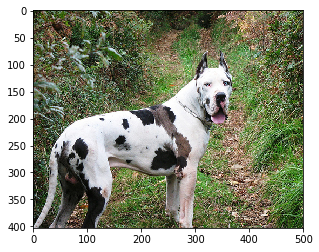

In [55]:
imshow(np.asarray(img_pil))

In [24]:
# define transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [25]:
# preprocess the image
img_tensor = preprocess(img_pil)

In [26]:

# resize the tensor (add dimension for batch)
img_tensor.unsqueeze_(0)



( 0 , 0 ,.,.) = 
  1.8037 -0.0287 -1.1075  ...   1.5639  1.5810  1.5639
  0.3823 -0.8849 -0.9877  ...   1.5982  1.5982  1.5810
 -1.0390 -1.0048  0.1083  ...   1.5982  1.5810  1.5810
           ...             ⋱             ...          
  0.0398  0.0398  0.0912  ...   0.5707  0.9132  1.2214
  0.0741  0.0569  0.0741  ...   1.7009  1.5639  1.5297
  0.0912  0.0912  0.0227  ...   1.4954  1.8037  1.8208

( 0 , 1 ,.,.) = 
  1.7283 -0.1800 -1.2654  ...   1.5182  1.5182  1.5007
  0.2402 -1.0378 -1.1253  ...   1.5707  1.5357  1.5182
 -1.1954 -1.1604 -0.0224  ...   1.5532  1.5532  1.5532
           ...             ⋱             ...          
 -0.0399 -0.0399 -0.0049  ...  -1.5630 -1.7731 -1.8256
 -0.0049 -0.0049 -0.0224  ...   0.1176 -0.2850 -0.5826
 -0.0049 -0.0224 -0.0574  ...  -0.5126  0.5903  0.7129

( 0 , 2 ,.,.) = 
  1.5768 -0.4624 -1.5953  ...   1.3154  1.3154  1.3328
 -0.0092 -1.3339 -1.4559  ...   1.3154  1.2805  1.2805
 -1.5081 -1.5081 -0.3230  ...   1.3502  1.3328  1.2457
           

In [27]:

# wrap input in variable
data = Variable(img_teJnsor, volatile=True) 


# apply model to input
model = models_dict['resnet']



# puts model in evaluation mode
# instead of (default)training mode
model = model.eval()



# apply data to model
output = model(data)



# return index corresponding to predicted class
pred_idx = output.data.numpy().argmax()



imagenet_classes_dict[pred_idx]


In [57]:
def get_pet_labels():
    dirs = os.listdir("pet_images/")
    petlabels_dic = {}
    # print(dirs)
    for image_file_name in dirs:
        label = ' '.join(image_file_name.split("_")[:-1])
        petlabels_dic[image_file_name] = label
    return petlabels_dic
   

In [56]:
def classifier(img_path, model_name):
    # load the image
    img_pil = Image.open(img_path)
    # define transforms
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    # preprocess the image
    img_tensor = preprocess(img_pil)
    # resize the tensor (add dimension for batch)
    img_tensor.unsqueeze_(0)
    # wrap input in variable
    data = Variable(img_tensor, volatile=True) 
    # apply model to input
    model = models_dict[model_name]
    # puts model in evaluation mode
    # instead of (default)training mode
    model = model.eval()
    # apply data to model
    output = model(data)
    # return index corresponding to predicted class
    pred_idx = output.data.numpy().argmax()
    return imagenet_classes_dict[pred_idx]

In [77]:
def classify_images():
    results_dic = {}
#     image_filename = random.choice(list(petlabels_dic.keys()))
    for image_filename in list(petlabels_dic.keys()):
        img_path = "./pet_images/" + image_filename
        label = petlabels_dic[image_filename]
        label = label.lower()
        classification = classifier(img_path, 'resnet')
        classification = classification.split(',')[0]
        classification = classification.lower()
        match = (1 if (label == classification) else 0)
#         print(classification)
#         print(label)
#         print(1 if (label == classification) else 0)
        results_dic[image_filename] = [label, classification, match]
    print(results_dic)
    return results_dic

In [80]:
results_dic = classify_images()

{'Great_pyrenees_05367.jpg': ['great pyrenees', 'kuvasz', 0], 'cat_07.jpg': ['cat', 'egyptian cat', 0], 'Dalmatian_04068.jpg': ['dalmatian', 'dalmatian', 1], 'Dalmatian_04017.jpg': ['dalmatian', 'dalmatian', 1], 'Boston_terrier_02303.jpg': ['boston terrier', 'boston bull', 0], 'Dalmatian_04037.jpg': ['dalmatian', 'dalmatian', 1], 'fox_squirrel_01.jpg': ['fox squirrel', 'fox squirrel', 1], 'gecko_80.jpg': ['gecko', 'tailed frog', 0], 'Great_dane_05320.jpg': ['great dane', 'great dane', 1], 'Beagle_01141.jpg': ['beagle', 'beagle', 1], 'Golden_retriever_05257.jpg': ['golden retriever', 'golden retriever', 1], 'Poodle_07927.jpg': ['poodle', 'standard poodle', 0], 'great_horned_owl_02.jpg': ['great horned owl', 'great grey owl', 0], 'Boston_terrier_02259.jpg': ['boston terrier', 'boston bull', 0], 'cat_01.jpg': ['cat', 'norwegian elkhound', 0], 'Beagle_01125.jpg': ['beagle', 'beagle', 1], 'Boxer_02426.jpg': ['boxer', 'boxer', 1], 'Boston_terrier_02285.jpg': ['boston terrier', 'boston bull',

In [81]:
list_of_dognames = []

with open('dognames.txt') as f:
    for line in f:
        add_dogname = [line.strip() for line in line.split(',')]
        list_of_dognames = list_of_dognames + add_dogname
print('list_of_dognames: ', list_of_dognames)
for key in list(results_dic.keys()):
    pet_image_label = results_dic[key][0]
    classifier_label = results_dic[key][1]
    results_dic[key].append(1 if pet_image_label in list_of_dognames else 0)
    results_dic[key].append(1 if classifier_label in list_of_dognames else 0)
print('results_dic: ', results_dic)

list_of_dognames:  ['chihuahua', 'japanese spaniel', 'maltese dog', 'maltese terrier', 'maltese', 'pekinese', 'pekingese', 'peke', 'shih-tzu', 'blenheim spaniel', 'papillon', 'toy terrier', 'rhodesian ridgeback', 'afghan hound', 'afghan', 'basset', 'basset hound', 'beagle', 'bloodhound', 'sleuthhound', 'bluetick', 'black-and-tan coonhound', 'walker hound', 'walker foxhound', 'english foxhound', 'redbone', 'borzoi', 'russian wolfhound', 'irish wolfhound', 'italian greyhound', 'whippet', 'ibizan hound', 'ibizan podenco', 'norwegian elkhound', 'elkhound', 'otterhound', 'otter hound', 'saluki', 'gazelle hound', 'scottish deerhound', 'deerhound', 'weimaraner', 'staffordshire bullterrier', 'staffordshire bull terrier', 'american staffordshire terrier', 'staffordshire terrier', 'american pit bull terrier', 'pit bull terrier', 'bedlington terrier', 'border terrier', 'kerry blue terrier', 'irish terrier', 'norfolk terrier', 'norwich terrier', 'yorkshire terrier', 'wire-haired fox terrier', 'lak

In [85]:
#calculates_results_stats
results_stats = {}
number_of_matched = 0
number_of_dogs = 0
number_of_classified_dogs = 0
for key in list(results_dic.keys()):
    number_of_matched = number_of_matched + results_dic[key][2]
    number_of_dogs = number_of_dogs + results_dic[key][3]
    number_of_classified_dogs = number_of_classified_dogs + results_dic[key][4]
results_stats['n_matched'] = number_of_matched
results_stats['n_dogs'] = number_of_dogs
results_stats['n_classified_as_dog'] = number_of_classified_dogs
results_stats['pct_matched'] = number_of_matched/len(list(results_dic.keys()))
results_stats['pct_dogs'] = number_of_dogs/len(list(results_dic.keys()))
results_stats['pct_classified_as_dog'] = number_of_classified_dogs/len(list(results_dic.keys()))
print('results_stats: ', results_stats)


number_of_matched:  21
number_of_dogs:  30
number_of_classified_dogs:  31
results_stats:  {'n_dogs': 30, 'n_classified_as_dog': 31, 'pct_dogs': 0.75, 'pct_matched': 0.525, 'pct_classified_as_dog': 0.775, 'n_matched': 21}


In [ ]:
#print_results
